# Ablauf

1) Daten einlesen
2) Daten aufbereiten
    -   Ausreißer identifizieren
3) GSMP-Kenndaten aufbereiten
4) Analyse
    

# 1. Daten einlesen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LOG_PATH = "shell-scripts/logs/"
LOG_NAME = "2024-02-05-12-40-00-baseworkers=0-count=90-STARTS"

#read first CSV
rawdata = pd.read_csv("CSV/2024-02-05_12-40-00 Pod_Process Power Consumption (W) in Namespace_ All-data-as-joinbyfield-2024-02-05 20_33_11.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read starting times
with open(LOG_PATH+LOG_NAME, "r") as file:
    start_times = file.readlines()

# remove newline-character, 
for i, time in enumerate(start_times):
    start_times[i] = time[:-1]


In [2]:
LOG_PATH = "shell-scripts/logs/"
LOG_NAME = "2024-02-16-20-31-00-baseworkers=0-count=30-STARTS"

#read first CSV
rawdata = pd.read_csv("CSV/2024-02-16 20-31-00 power.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read starting times
with open(LOG_PATH+LOG_NAME, "r") as file:
    start_times = file.readlines()

# remove newline-character, 
for i, time in enumerate(start_times):
    start_times[i] = time[:-1]

In [35]:
# remove irrelevant columns: 

columns_to_keep = rawdata.columns[~rawdata.columns.str.contains('measuring-endpoints|monitoring|console-worker|tasklist|operate|bpmndeployment|processstart|elasticsearch|connectors|load-controller')]
data = rawdata.loc[:, columns_to_keep]


data.columns

Index(['camunda-platform-zeebe-0 / camunda8 / PKG',
       'camunda-platform-zeebe-gateway-5ff76496c4-wrsml / camunda8 / PKG',
       'coredns-6799fbcd5-hv5gw / kube-system / PKG',
       'helm-install-traefik-crd-g2kkj / kube-system / PKG',
       'helm-install-traefik-v6j69 / kube-system / PKG',
       'local-path-provisioner-84db5d44d9-6lpch / kube-system / PKG',
       'metrics-server-67c658944b-p7nxh / kube-system / PKG',
       'svclb-traefik-b23bf1fe-nwmmj / kube-system / PKG',
       'traefik-f4564c4f4-g8jd6 / kube-system / PKG',
       'system_processes / system / PKG',
       ...
       'restworkerjava-865c45bdb4-q2slg / worker / OTHER',
       'restworkerjava-865c45bdb4-r7jm4 / worker / OTHER',
       'restworkerjava-865c45bdb4-tqnbh / worker / OTHER',
       'restworkerjava-865c45bdb4-tzrnv / worker / OTHER',
       'restworkerjava-865c45bdb4-w2vgm / worker / OTHER',
       'restworkerjava-865c45bdb4-wt494 / worker / OTHER',
       'restworkerjava-865c45bdb4-wx4cd / worker 

In [4]:
# rename 'kube-system' names to avoid double picking with 'system' namespace

new_columns = []
for i, col in enumerate(data.columns):
    if 'kube-system' in col:
        new_columns.append(col.replace('kube-system', 'kube'))
    else:
        new_columns.append(col)

data.columns = new_columns

In [5]:
# extract measurements. use list of start_times and measurements_per_cycle (amount of datapoints)
def split_data_into_cycles(df, start_times, measurements_per_cycle):
    cycles = []
    # Select all rows belonging to a cycle
    for item in start_times:
        temp = pd.DataFrame()

        index = df.index.get_loc(item) + 1

        temp = df.iloc[index:index + measurements_per_cycle,:]
        temp = temp.dropna(how="all", axis=1)

        cycles.append(temp)
    
    return cycles;

# every Cycle with 30 measurements is 1 entry in list
STEPS_PER_CYCLE = 30 # 5 Min * 6 Scrapes/Min

cycles = split_data_into_cycles(data, start_times,STEPS_PER_CYCLE)


In [6]:
# read namespaces from columns. 
# This relies on grafana CSV-outputs using '/' as a divider: "pod / namespace / domain"
def extract_namespaces(df):
    namespaces = []
    for col in df.columns:
        split_col = col.split('/')
        if len(split_col) > 1:
            namespace = split_col[1].strip()
            if namespace not in namespaces:
                namespaces.append(namespace)
    return namespaces;


In [7]:
# for each cycle, group all pods from namespace
def group_namespaces_per_cycle(cycles):
    grouped_cycles = []
    namespaces = extract_namespaces(data)

    for item in cycles:
        temp = pd.DataFrame()

        for namespace in namespaces:
            namespace_cols = [col for col in item.columns if namespace in col]
            temp[namespace] = item[namespace_cols].sum(axis=1)  

        grouped_cycles.append(temp)
    
    return grouped_cycles;


cycles_by_namespace = group_namespaces_per_cycle(cycles)

In [8]:
# create relative timestamps

def create_relative_timestamps(min, max, interval):
    elapsed_times = []
    for i in range(min,int(max/interval)):
        s = i * interval % 60
        m = int(i / (60 / interval))
        elapsed_times.append("{:02d}:{:02d}".format(m,s))

    return elapsed_times;

elapsed_times = create_relative_timestamps(0, 300, 10)

# elapsed_times


In [9]:
# create single dataframe for namespace for better readability
def isolate_namespace_per_cycle(namespace, cycles_list):
    df = pd.DataFrame(index=elapsed_times)
    
    for item in cycles_list:
        temp = item[namespace]
        temp.index = elapsed_times
        
        df[item.index[0]] = temp
    
    return df;

all_camunda_series = isolate_namespace_per_cycle("camunda8", cycles_by_namespace)
all_system_series = isolate_namespace_per_cycle("system", cycles_by_namespace)
all_worker_series = isolate_namespace_per_cycle("worker", cycles_by_namespace)
all_kube_system_series = isolate_namespace_per_cycle("kube", cycles_by_namespace)

print(all_camunda_series.median().median())
print(all_camunda_series.median().std())


0.5455749999999999
0.011233419582533264


## Leerlauf-Stromverbrauch abziehen

Gewählte Methode: individuelle Betrachtung der 10-Sekunden-Intervalle

In [11]:
def remove_idle_power(df):
    idle_pattern = pd.Series()
        
    # create idle series in temp
    idle_base_pattern = df.iloc[24:, :].median(axis=1)

    for i in range(3):

        idle_base_pattern[i] = (idle_base_pattern[i] + idle_base_pattern[i + 3]) / 2

    idle_base_pattern = idle_base_pattern.drop(['04:30','04:40','04:50'])
    
    # repeat the base pattern until length of df.index is reached
    while len(idle_pattern) < len(df.index):
        idle_pattern = pd.concat([idle_pattern, idle_base_pattern])
    
    idle_pattern = idle_pattern.apply(pd.to_numeric, errors='coerce')
    idle_pattern.index = df.index

    temp = df.sub(idle_pattern, axis='index')

    return temp, idle_pattern


camunda_no_idle , camunda_idle_pattern = remove_idle_power(all_camunda_series)
worker_no_idle , worker_idle_pattern = remove_idle_power(all_worker_series)
kube_no_idle , kube_idle_pattern = remove_idle_power(all_kube_system_series)
system_no_idle , system_idle_pattern = remove_idle_power(all_system_series)

    

camunda_no_idle = all_camunda_series
worker_no_idle = all_worker_series
kube_no_idle  = all_kube_system_series
system_no_idle = all_system_series

## Ausreißer löschen

In [12]:
def filter_outliers_iqr_per_row(row, multiplier=1.5):
    Q1 = row.quantile(0.25)
    Q3 = row.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = ((row < lower_bound) | (row > upper_bound))
    return row[~outliers]

# Function to apply the IQR method for each row in a DataFrame
def filter_outliers_iqr(df, multiplier=1.5):
    return df.apply(filter_outliers_iqr_per_row, axis=1).apply(pd.to_numeric, errors='coerce')

camunda_clean = filter_outliers_iqr(camunda_no_idle)
worker_clean = filter_outliers_iqr(worker_no_idle)
kube_clean = filter_outliers_iqr(kube_no_idle)
system_clean = filter_outliers_iqr(system_no_idle)

### Plotting

In [13]:
# create xlabels

xlabels = [f"{camunda_clean.index[i]} - {camunda_clean.index[i + 1]}" for i in range(len(camunda_clean.index) - 1)]
xlabels.append("04:50 - 05:00")

xlabels

['00:00 - 00:10',
 '00:10 - 00:20',
 '00:20 - 00:30',
 '00:30 - 00:40',
 '00:40 - 00:50',
 '00:50 - 01:00',
 '01:00 - 01:10',
 '01:10 - 01:20',
 '01:20 - 01:30',
 '01:30 - 01:40',
 '01:40 - 01:50',
 '01:50 - 02:00',
 '02:00 - 02:10',
 '02:10 - 02:20',
 '02:20 - 02:30',
 '02:30 - 02:40',
 '02:40 - 02:50',
 '02:50 - 03:00',
 '03:00 - 03:10',
 '03:10 - 03:20',
 '03:20 - 03:30',
 '03:30 - 03:40',
 '03:40 - 03:50',
 '03:50 - 04:00',
 '04:00 - 04:10',
 '04:10 - 04:20',
 '04:20 - 04:30',
 '04:30 - 04:40',
 '04:40 - 04:50',
 '04:50 - 05:00']

[Text(0, 0, '00:00 - 00:10'),
 Text(1, 0, '00:10 - 00:20'),
 Text(2, 0, '00:20 - 00:30'),
 Text(3, 0, '00:30 - 00:40'),
 Text(4, 0, '00:40 - 00:50'),
 Text(5, 0, '00:50 - 01:00'),
 Text(6, 0, '01:00 - 01:10'),
 Text(7, 0, '01:10 - 01:20'),
 Text(8, 0, '01:20 - 01:30'),
 Text(9, 0, '01:30 - 01:40'),
 Text(10, 0, '01:40 - 01:50'),
 Text(11, 0, '01:50 - 02:00'),
 Text(12, 0, '02:00 - 02:10'),
 Text(13, 0, '02:10 - 02:20'),
 Text(14, 0, '02:20 - 02:30'),
 Text(15, 0, '02:30 - 02:40'),
 Text(16, 0, '02:40 - 02:50'),
 Text(17, 0, '02:50 - 03:00'),
 Text(18, 0, '03:00 - 03:10'),
 Text(19, 0, '03:10 - 03:20'),
 Text(20, 0, '03:20 - 03:30'),
 Text(21, 0, '03:30 - 03:40'),
 Text(22, 0, '03:40 - 03:50'),
 Text(23, 0, '03:50 - 04:00'),
 Text(24, 0, '04:00 - 04:10'),
 Text(25, 0, '04:10 - 04:20'),
 Text(26, 0, '04:20 - 04:30'),
 Text(27, 0, '04:30 - 04:40'),
 Text(28, 0, '04:40 - 04:50'),
 Text(29, 0, '04:50 - 05:00')]

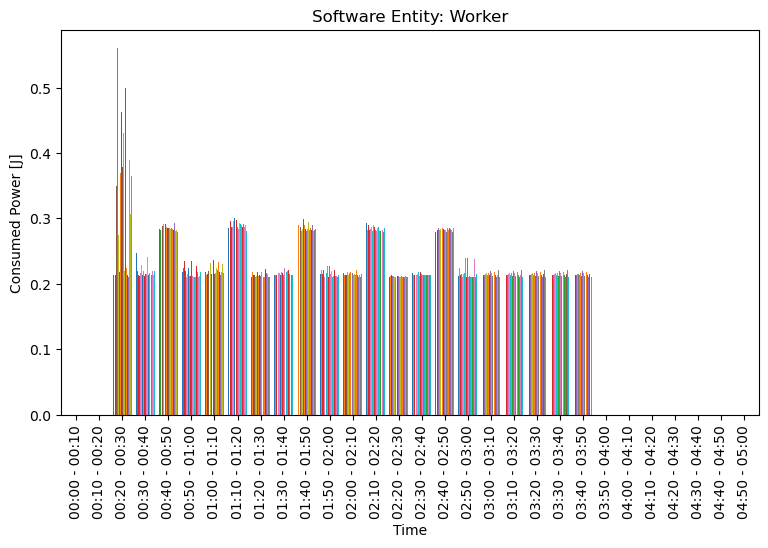

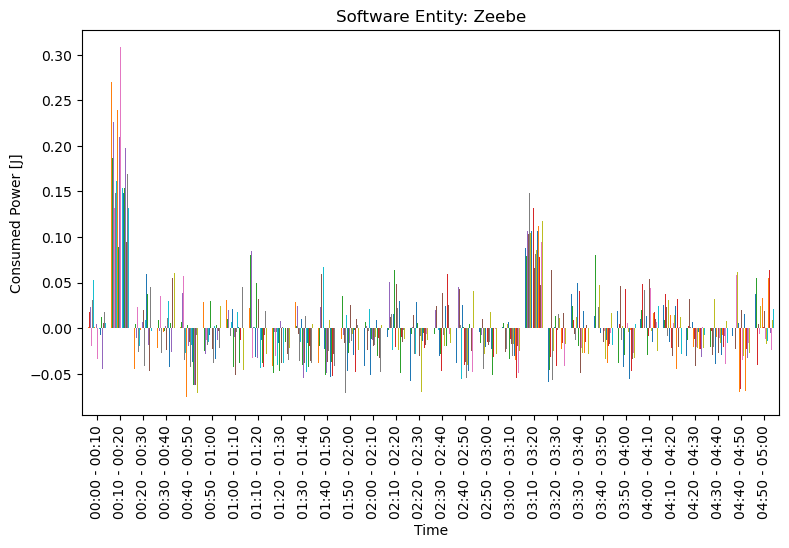

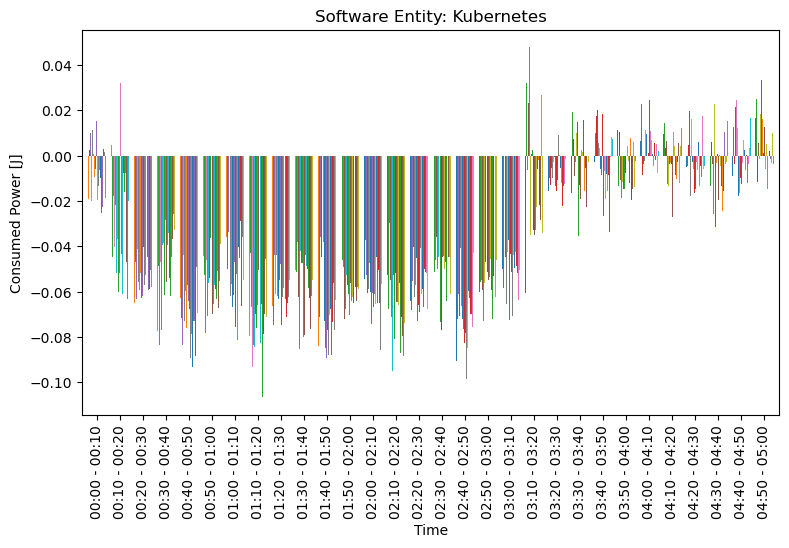

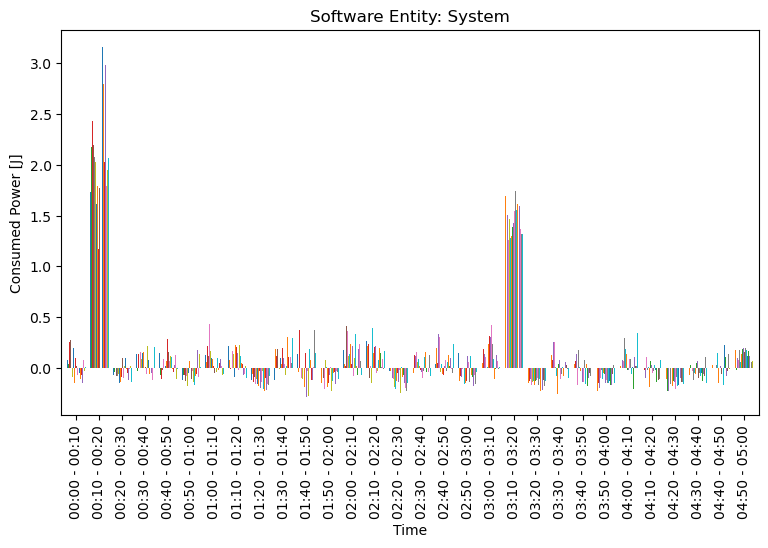

In [14]:
# plot results
ylim=[0,10]
xlim = [0,31] 
figsize = [9,5]
alpha=1
x_ticks = [0,6,12,18,24]
grid=False
width=0.8

ax = worker_clean.plot(width=width,
                kind='bar',
                legend=False,
                alpha = alpha,
                figsize = figsize,
                # xticks = x_ticks,
                grid = grid,
                title = "Software Entity: Worker",
                xlabel='Time',
                ylabel='Consumed Power [J]',
                xlim = xlim)
ax.set_xticklabels(xlabels)

ax = camunda_clean.plot(width=width,
                kind='bar',
                legend=False,
                alpha = alpha,
                figsize = figsize,
                # xticks = x_ticks,
                grid = grid,
                title = "Software Entity: Zeebe",
                xlabel='Time',
                ylabel='Consumed Power [J]',
                xlim = xlim)
ax.set_xticklabels(xlabels)

ax = kube_clean.plot(width=width,
                kind='bar',
                legend=False,
                alpha = alpha,
                figsize = figsize,
                # xticks = x_ticks,
                grid = grid,
                title = "Software Entity: Kubernetes",
                xlabel='Time',
                ylabel='Consumed Power [J]',
                xlim = xlim)
ax.set_xticklabels(xlabels)

ax = system_clean.plot(width=width,
                kind='bar',
                legend=False,
                alpha = alpha,
                figsize = figsize,
                # xticks = x_ticks,
                grid = grid,
                title = "Software Entity: System",
                xlabel='Time',
                ylabel='Consumed Power [J]',
                xlim = xlim)
ax.set_xticklabels(xlabels)



# camunda_no_idle_clean.plot(width=width, kind='bar', legend=False, alpha = alpha,  figsize = figsize, xticks = x_ticks, grid = grid, title = "Software Entity: Zeebe", xlabel='Time', ylabel='Consumed Power [W]', xlim = xlim)

In [15]:
camunda_clean

,2024-02-16 20:34:10,2024-02-16 20:39:10,2024-02-16 20:44:10,2024-02-16 20:49:10,2024-02-16 20:54:10,2024-02-16 20:59:10,2024-02-16 21:04:10,2024-02-16 21:09:10,2024-02-16 21:14:10,2024-02-16 21:19:10,...,2024-02-16 22:14:10,2024-02-16 22:19:10,2024-02-16 22:24:10,2024-02-16 22:29:10,2024-02-16 22:34:10,2024-02-16 22:39:10,2024-02-16 22:44:10,2024-02-16 22:49:10,2024-02-16 22:54:10,2024-02-16 22:59:10
00:00,-0.010525,0.001175,0.018175,0.018175,0.023075,0.044475,-0.019525,0.030475,0.037475,0.052475,...,-0.007225,-0.039925,0.012175,-0.034225,-0.045125,0.005175,-0.011525,0.017775,0.005875,0.005175
00:10,0.152275,0.269775,0.186275,0.238675,0.226075,0.201375,0.132075,0.148275,0.209875,0.161675,...,0.148575,0.094975,0.153375,0.156475,0.197075,0.094275,0.188775,0.169175,0.126875,0.131775
00:20,-0.003875,-0.044875,0.004725,-0.050175,-0.010575,-0.015875,0.023125,-0.026575,-0.008275,-0.019875,...,0.059125,NaN,0.037325,0.002025,-0.017975,-0.046875,-0.038975,0.045425,-0.005275,-0.003675
00:30,0.054775,-0.022125,0.008775,-0.014125,-0.002725,-0.001825,0.035475,-0.027425,0.010175,-0.000125,...,-0.042525,-0.026525,0.005875,0.098775,-0.026125,0.055475,-0.039825,NaN,0.060175,-0.013125
00:40,0.025675,0.000975,0.006275,-0.009225,0.038775,-0.002025,0.057275,-0.035025,NaN,-0.027025,...,-0.036925,-0.011125,-0.062925,-0.037325,-0.062625,-0.062325,0.028775,-0.007725,-0.070925,0.002075
00:50,-0.050175,0.028125,-0.025575,-0.000875,-0.028875,-0.000875,-0.013175,-0.018875,-0.050875,-0.014775,...,-0.034175,-0.003875,0.003825,-0.057875,-0.013475,-0.002875,-0.014475,-0.022175,0.023825,-0.036175
01:00,-0.017525,0.030775,0.009475,0.010875,0.019775,-0.017825,NaN,-0.008425,0.011775,0.007175,...,0.001475,-0.055225,-0.037825,-0.012925,0.014875,0.000275,0.004475,0.045475,-0.045825,0.003175
01:10,0.030575,0.021575,0.079975,-0.032725,0.084675,0.042575,-0.032925,0.001675,0.021875,0.000675,...,-0.013025,-0.001625,-0.038625,-0.042425,-0.050325,-0.007025,0.014675,0.019275,-0.028025,-0.036625
01:20,-0.051875,-0.041175,-0.049575,-0.051875,-0.003875,-0.015875,-0.030175,-0.003875,-0.002875,-0.040175,...,NaN,-0.038175,-0.014875,-0.000175,-0.043775,-0.028575,-0.002175,-0.035175,-0.022175,-0.066575
01:30,-0.022225,0.028475,0.002475,-0.028125,0.024475,-0.006525,0.024175,-0.036425,-0.027825,-0.015525,...,-0.016125,-0.046125,-0.042825,-0.019225,0.054675,-0.035725,0.062375,-0.038125,0.004475,-0.001825


[Text(1, 0, '00:00 - 00:10'),
 Text(2, 0, '00:10 - 00:20'),
 Text(3, 0, '00:20 - 00:30'),
 Text(4, 0, '00:30 - 00:40'),
 Text(5, 0, '00:40 - 00:50'),
 Text(6, 0, '00:50 - 01:00'),
 Text(7, 0, '01:00 - 01:10'),
 Text(8, 0, '01:10 - 01:20'),
 Text(9, 0, '01:20 - 01:30'),
 Text(10, 0, '01:30 - 01:40'),
 Text(11, 0, '01:40 - 01:50'),
 Text(12, 0, '01:50 - 02:00'),
 Text(13, 0, '02:00 - 02:10'),
 Text(14, 0, '02:10 - 02:20'),
 Text(15, 0, '02:20 - 02:30'),
 Text(16, 0, '02:30 - 02:40'),
 Text(17, 0, '02:40 - 02:50'),
 Text(18, 0, '02:50 - 03:00'),
 Text(19, 0, '03:00 - 03:10'),
 Text(20, 0, '03:10 - 03:20'),
 Text(21, 0, '03:20 - 03:30'),
 Text(22, 0, '03:30 - 03:40'),
 Text(23, 0, '03:40 - 03:50'),
 Text(24, 0, '03:50 - 04:00'),
 Text(25, 0, '04:00 - 04:10'),
 Text(26, 0, '04:10 - 04:20'),
 Text(27, 0, '04:20 - 04:30'),
 Text(28, 0, '04:30 - 04:40'),
 Text(29, 0, '04:40 - 04:50'),
 Text(30, 0, '04:50 - 05:00')]

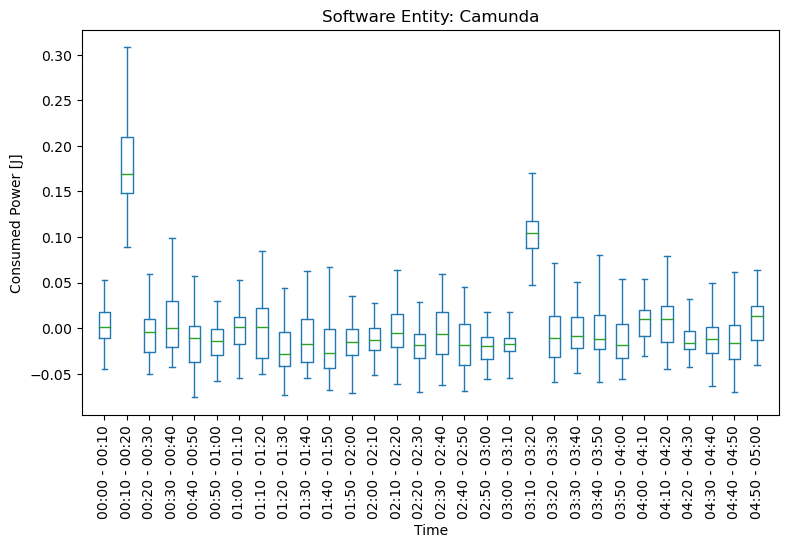

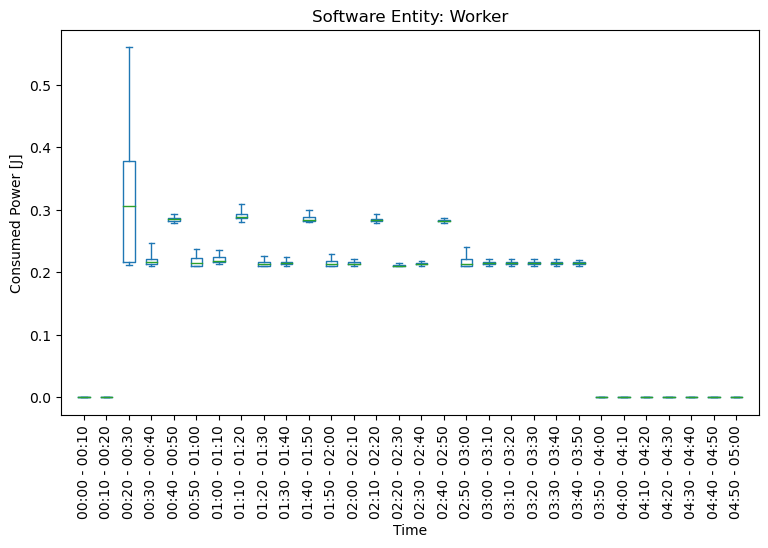

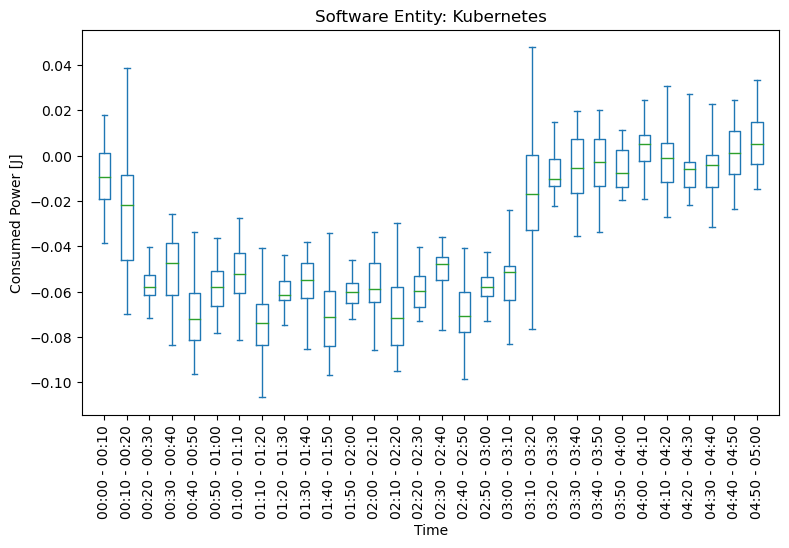

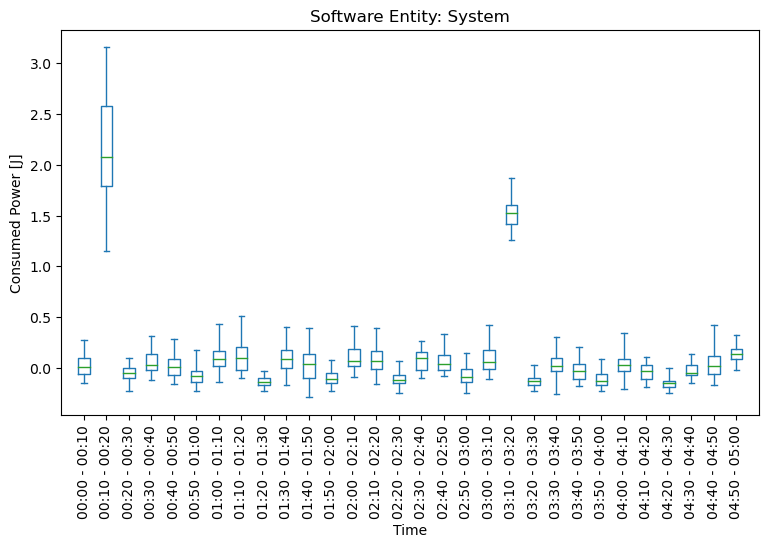

In [16]:
whis = [0,100]



camunda_clean_T = camunda_clean.T

ax = camunda_clean_T.plot(legend=False, 
                     kind='box', 
                     rot=90, 
                     whis= whis, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Software Entity: Camunda", 
                     xlabel='Time', 
                     ylabel='Consumed Power [J]')
ax.set_xticklabels(xlabels)

worker_clean_T = worker_clean.T

ax = worker_clean_T.plot(legend=False, 
                     kind='box', 
                     rot=90, 
                     whis= whis, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Software Entity: Worker", 
                     xlabel='Time', 
                     ylabel='Consumed Power [J]')
ax.set_xticklabels(xlabels)

kube_clean_T = kube_clean.T

ax = kube_clean_T.plot(legend=False, 
                     kind='box', 
                     rot=90, 
                     whis= whis, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Software Entity: Kubernetes", 
                     xlabel='Time', 
                     ylabel='Consumed Power [J]')
ax.set_xticklabels(xlabels)

system_clean_T = system_clean.T

ax = system_clean_T.plot(legend=False, 
                     kind='box', 
                     rot=90, 
                     whis= whis, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Software Entity: System", 
                     xlabel='Time', 
                     ylabel='Consumed Power [J]')
ax.set_xticklabels(xlabels)

# print(camunda_clean.std(axis=1).median())
# print(camunda_clean.std(axis=0).median())
# print(camunda_clean.median(axis=1))
# print(camunda_clean.median(axis=0))

<Axes: >

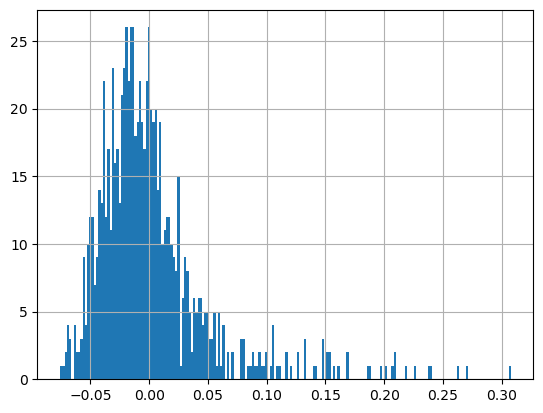

In [17]:
camunda_clean.stack().hist(bins = 200)

-0.009587500000000027


<Axes: title={'center': 'Software Entity: Camunda'}, xlabel='Time', ylabel='Consumed Power [J]'>

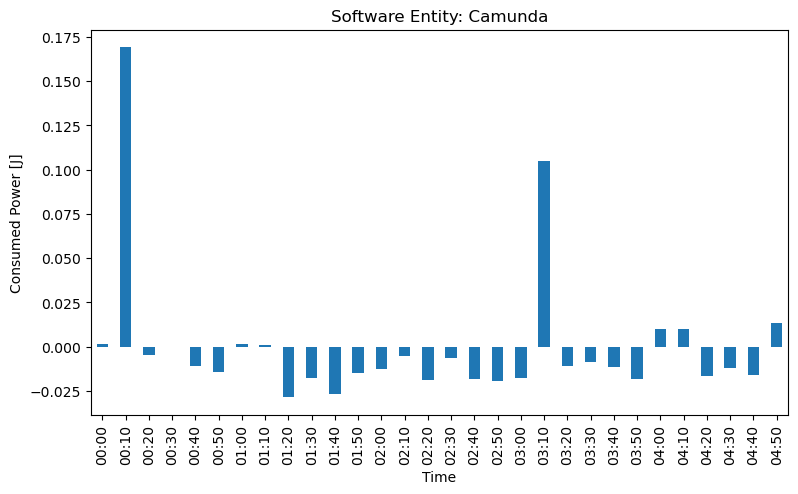

In [18]:
print(camunda_clean.median().median())
camunda_clean.median(axis='columns').plot(legend=False, 
                     kind='bar', 
                     rot=90, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Software Entity: Camunda", 
                     xlabel='Time', 
                     ylabel='Consumed Power [J]')

<Axes: title={'center': 'Software Entity: Worker'}, xlabel='Time', ylabel='Consumed Power [J]'>

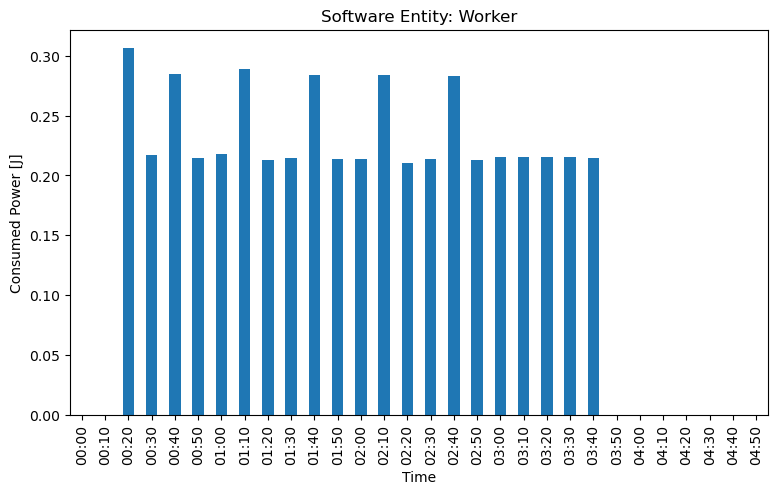

In [19]:
worker_clean.median(axis='columns').plot(legend=False, 
                     kind='bar', 
                     rot=90, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Software Entity: Worker", 
                     xlabel='Time', 
                     ylabel='Consumed Power [J]')

<Axes: title={'center': 'Software Entity: Kubernetes'}, xlabel='Time', ylabel='Consumed Power [J]'>

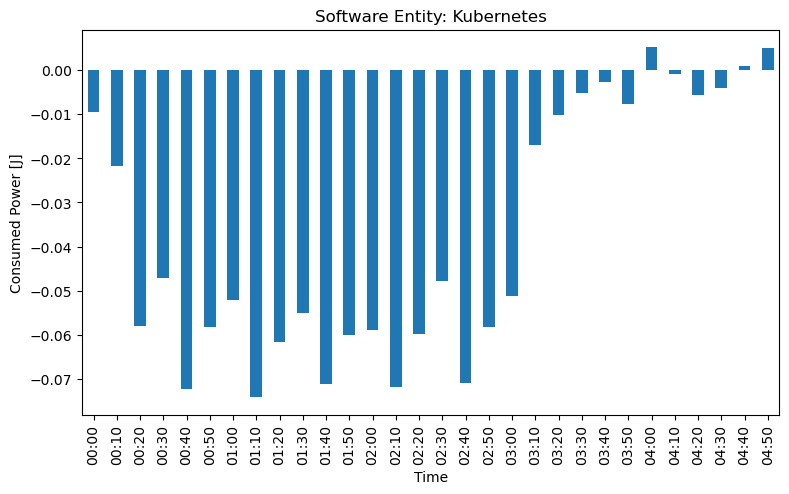

In [20]:
kube_clean.median(axis='columns').plot(legend=False, 
                     kind='bar', 
                     rot=90, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Software Entity: Kubernetes", 
                     xlabel='Time', 
                     ylabel='Consumed Power [J]')

<Axes: title={'center': 'Software Entity: System'}, xlabel='Time', ylabel='Consumed Power [J]'>

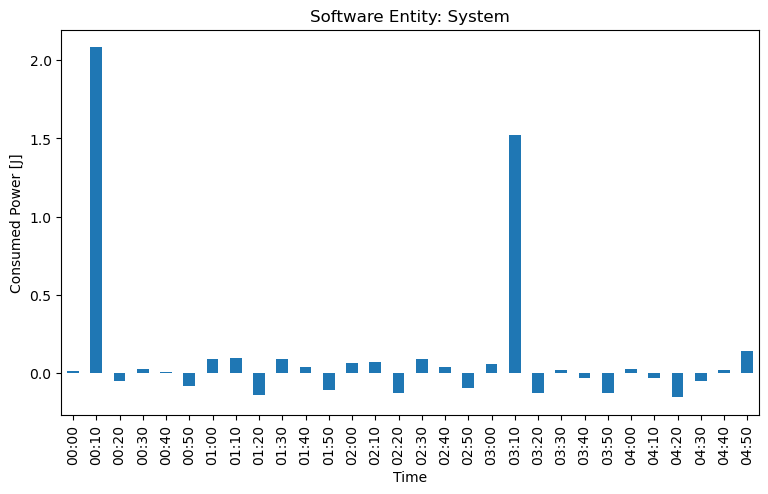

In [21]:
system_clean.median(axis='columns').plot(legend=False, 
                     kind='bar', 
                     rot=90, 
                     figsize=figsize,  
                     xlim=xlim, 
                     grid=grid, 
                     title="Software Entity: System", 
                     xlabel='Time', 
                     ylabel='Consumed Power [J]')

In [22]:
camunda_clean.median(axis=1).reset_index(drop=True)

0     0.001175
1     0.169175
2    -0.004575
3    -0.000125
4    -0.011125
5    -0.014475
6     0.001475
7     0.000675
8    -0.028575
9    -0.017675
10   -0.026825
11   -0.015175
12   -0.012525
13   -0.005425
14   -0.018875
15   -0.006525
16   -0.018325
17   -0.019475
18   -0.017675
19    0.104675
20   -0.010975
21   -0.008825
22   -0.011425
23   -0.018175
24    0.010175
25    0.009975
26   -0.016575
27   -0.012325
28   -0.016325
29    0.013125
dtype: float64

### Median Zeitreihen plotten

<Axes: >

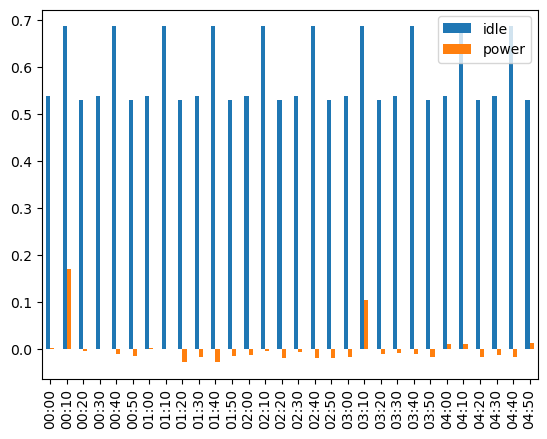

In [23]:
stack_camunda = pd.DataFrame()

stack_camunda['idle'] = camunda_idle_pattern
stack_camunda['power'] = camunda_clean.median(axis=1)

stack_camunda.plot(kind='bar')

### Phasenlängen anpassen

In [24]:
def create_check_for_event_length(df, start_a, stop_a, start_b, stop_b):

    min1_medians = df.iloc[start_a:stop_a,:].T.median()
    idle_worker_q75 = df.iloc[start_b:stop_b,:].stack().reset_index(drop=True).quantile(0.75)

    return (min1_medians <= idle_worker_q75)

is_idle_start = pd.DataFrame()

start_a = 0
stop_a = 6
start_b = 6
stop_b = 18

is_idle_start['worker'] = create_check_for_event_length(worker_clean, start_a, stop_a, start_b, stop_b)
is_idle_start['zeebe'] = create_check_for_event_length(camunda_clean, start_a, stop_a, start_b, stop_b)
is_idle_start['kubernetes'] = create_check_for_event_length(kube_clean, start_a, stop_a, start_b, stop_b)
is_idle_start['system'] = create_check_for_event_length(system_clean, start_a, stop_a, start_b, stop_b)

is_idle_start

,worker,zeebe,kubernetes,system
00:00,True,True,False,True
00:10,True,False,False,False
00:20,False,True,True,True
00:30,True,True,False,True
00:40,False,True,True,True
00:50,True,True,True,True


In [25]:
is_idle_stop = pd.DataFrame()

start_a = 18
stop_a = 24
start_b = 24
stop_b = 30

is_idle_stop['worker'] = create_check_for_event_length(worker_clean, start_a, stop_a, start_b, stop_b)
is_idle_stop['zeebe'] = create_check_for_event_length(camunda_clean, start_a, stop_a, start_b, stop_b)
is_idle_stop['kubernetes'] = create_check_for_event_length(kube_clean, start_a, stop_a, start_b, stop_b)
is_idle_stop['system'] = create_check_for_event_length(system_clean, start_a, stop_a, start_b, stop_b)

is_idle_stop

,worker,zeebe,kubernetes,system
03:00,False,True,True,True
03:10,False,False,True,False
03:20,False,True,True,True
03:30,False,True,True,True
03:40,False,True,True,True
03:50,True,True,True,True


#### Start

In [36]:
start_interval_begin = 0
start_interval_end = 4

start = pd.Series()
start['Event-Duration'] = '20 Sec'
start['Metric'] = 'per event'
start['Median Usage Worker'] = worker_clean.median(axis='columns')[start_interval_begin:start_interval_end].sum()
# start['Median Usage zeebe'] = camunda_clean.median(axis='columns')[start_interval_begin:start_interval_end].sum()
# start['Median Usage Kubernetees'] = kube_clean.median(axis='columns')[start_interval_begin:start_interval_end].sum()
start['Median Usage System'] = system_clean.median(axis='columns')[start_interval_begin:start_interval_end].sum()
start['Median Sum'] = start[2:6].sum()



#### Worker-Leerlauf

In [37]:
worker_idle = pd.Series()
worker_idle['Event-Duration'] = '1 Min'
worker_idle['Metric'] = 'per event'
worker_idle['Median Usage Worker'] = worker_clean.median(axis='columns')[2:18].sum() / (16/6)
# worker_idle['Median Usage zeebe'] = camunda_clean.median(axis='columns')[2:18].sum()
# worker_idle['Median Usage Kubernetees'] = kube_clean.median(axis='columns')[2:18].sum()
worker_idle['Median Usage System'] = system_clean.median(axis='columns')[2:18].sum() / (16/6)
worker_idle['Median Sum'] = worker_idle[2:6].sum()

#### Stopping

In [38]:
stop_interval_begin = 18
stop_interval_end = 20

stop = pd.Series()
stop['Event-Duration'] = '20 sec'
stop['Metric'] = 'per event'
stop['Median Usage Worker'] = worker_clean.median(axis='columns')[stop_interval_begin:stop_interval_end].sum()
# stop['Median Usage zeebe'] = camunda_clean.median(axis='columns')[stop_interval_begin:stop_interval_end].sum()
# stop['Median Usage Kubernetees'] = kube_clean.median(axis='columns')[stop_interval_begin:stop_interval_end].sum()
stop['Median Usage System'] = system_clean.median(axis='columns')[stop_interval_begin:stop_interval_end].sum()
stop['Median Sum'] = stop[2:6].sum()

In [39]:
phases = pd.DataFrame()

phases['start'] = start
phases['stop'] = stop
phases['idle worker'] = worker_idle

phases

,start,stop,idle worker
Event-Duration,20 Sec,20 sec,1 Min
Metric,per event,per event,per event
Median Usage Worker,0.5232,0.43,1.452056
Median Usage System,2.077175,1.5828,0.013294
Median Sum,2.600375,2.0128,1.46535


In [40]:
total_cost_scaling = phases.loc['Median Sum','start'] + phases.loc['Median Sum','stop']

time_ratio_scaling = total_cost_scaling / phases.loc['Median Sum', 'idle worker']

print(total_cost_scaling, time_ratio_scaling)

4.613175 3.148172791483263


### Start

1) Berechne Median der 10s-Intervalle in Min 2,3
2) Berechne Unterschied jedes 10s Intervalls in Min 1 zu Median(Min2,3)
3) Ab welchem Unterschied wird das Min1 Intervall zur Baseline gezählt?
    -> initaler gRPC-Call bei Zeebe?

In [41]:
# create array for all indicators
namespace_indicators = []

#set limits of phases (index of datapoint)
worker_start_lim = [0, 3]
idle_worker_lim = [3, 18] # min2,3
worker_stop_lim = [18, 22] #min4
idle_system = [22, 30] # min5


# go through each cycle and calculate:
# min2+3    median
# min5      median

def generate_indicators(all_namespace_series):
   temp = pd.DataFrame()

   temp.loc['start', 'median'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().median()
   temp.loc['idle_worker', 'median'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().median()
   temp.loc['stop', 'median'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().median()
   temp.loc['idle_system', 'median'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().median()
   
   temp.loc['start', 'mean'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().mean()
   temp.loc['idle_worker', 'mean'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().mean()
   temp.loc['stop', 'mean'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().mean()
   temp.loc['idle_system', 'mean'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().mean()

   temp.loc['start', 'min'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].min(axis=0).min()
   temp.loc['idle_worker', 'min'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].min(axis=0).min()
   temp.loc['stop', 'min'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].min(axis=0).min()
   temp.loc['idle_system', 'min'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].min(axis=0).min()

   temp.loc['start', 'max'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].max(axis=0).max()
   temp.loc['idle_worker', 'max'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].max(axis=0).max()
   temp.loc['stop', 'max'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].max(axis=0).max()
   temp.loc['idle_system', 'max'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].max(axis=0).max()

   temp['span'] = temp['max'] - temp['min']

   temp.loc['start', 'std'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().std()
   temp.loc['idle_worker', 'std'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().std()
   temp.loc['stop', 'std'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().std()
   temp.loc['idle_system', 'std'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().std()

   temp.loc['start', 'variance'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().var()
   temp.loc['idle_worker', 'variance'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().var()
   temp.loc['stop', 'variance'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().var()
   temp.loc['idle_system', 'variance'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().var()

   temp.loc['start', 'IQR'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().quantile(0.75) - all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack().quantile(0.25)
   temp.loc['idle_worker', 'IQR'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().quantile(0.75) - all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack().quantile(0.25)
   temp.loc['stop', 'IQR'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().quantile(0.75) - all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack().quantile(0.25)
   temp.loc['idle_system', 'IQR'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().quantile(0.75) - all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack().quantile(0.25)

   # add trimmed mean, winsorized mean, mae

   return temp;

camunda_indicator = generate_indicators(all_camunda_series)

camunda_indicator


,median,mean,min,max,span,std,variance,IQR
start,0.55530,0.652038,0.4804,1.3259,0.8455,0.174491,0.030447,0.30270
idle_worker,0.54065,0.581556,0.4568,2.0769,1.6201,0.110714,0.012258,0.13795
stop,0.54125,0.598195,0.4713,0.8793,0.4080,0.120325,0.014478,0.21900
idle_system,0.55825,0.594016,0.4750,0.8771,0.4021,0.085582,0.007324,0.14695


In [42]:
def generate_indicators_by_time(all_namespace_series):
    temp = pd.DataFrame()

    temp['mean'] = all_namespace_series.mean(axis=1)
    temp['median'] = all_namespace_series.median(axis=1)
    temp['min'] = all_namespace_series.min(axis=1)
    temp['max'] = all_namespace_series.max(axis=1)
    temp['span'] = temp['max'] -temp['min']
    temp['std'] = all_namespace_series.std(axis=1)
    temp['var'] = all_namespace_series.var(axis=1)
    temp['IQR'] = all_namespace_series.quantile(0.75,axis=1) - all_namespace_series.quantile(0.25, axis=1)


    return temp

#camunda_time_indicator = generate_indicators_by_time(camunda_clean)

#camunda_time_indicator.plot()

In [43]:
def extract_phase_indicators(all_namespace_series):
   temp = pd.DataFrame()

   temp['start'] = all_namespace_series.iloc[worker_start_lim[0]:worker_start_lim[1],:].stack()
   temp['idle_worker'] = all_namespace_series.iloc[idle_worker_lim[0]:idle_worker_lim[1],:].stack()
   temp['stop'] = all_namespace_series.iloc[worker_stop_lim[0]:worker_stop_lim[1],:].stack()
   temp['idle_system'] = all_namespace_series.iloc[idle_system[0]:idle_system[1],:].stack()

   # add trimmed mean, winsorized mean, mae

   return temp;


#camunda_phases = extract_phase_indicators(camunda_clean)

camunda_phases

NameError: name 'camunda_phases' is not defined

In [ ]:
def create_phase_column(df, limits=[0,1,17,20,29],names=["start", "idle_worker","stop", "idle_system"]):
    current_group = 0
    buckets= []
    
    for i in range(len(df.index)):
        buckets.append(names[current_group])
        if i == limits[current_group +1]:
            current_group = current_group+1
    
    df['bucket'] = buckets
    return df

#camunda_clean_phases = create_phase_column(camunda_clean)



<Axes: >

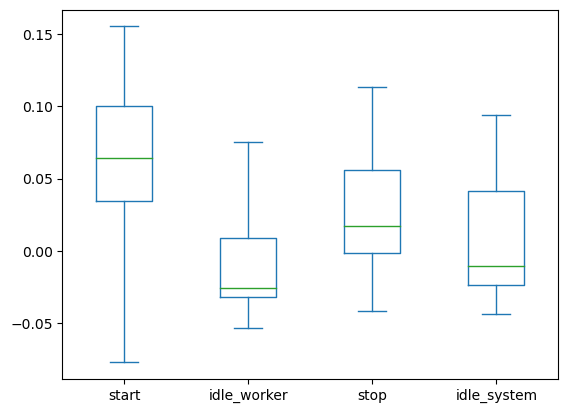

In [ ]:
def extract_phases(df):
    bucket_sizes = df['bucket'].value_counts()

    # create power sum
    start = df[df['bucket'] == 'start'].sum(axis=0).drop('bucket')
    idle_worker = df[df['bucket'] == 'idle_worker'].sum(axis=0).drop('bucket')
    stop = df[df['bucket'] == 'stop'].sum(axis=0).drop('bucket')
    idle_system = df[df['bucket'] == 'idle_system'].sum(axis=0).drop('bucket')

    # divide by amount of 30 second segments
    start = start / bucket_sizes['start']
    idle_worker = idle_worker / bucket_sizes['idle_worker']
    stop = stop / bucket_sizes['stop']
    idle_system = idle_system / bucket_sizes['idle_system']

    temp = pd.concat([start, idle_worker, stop, idle_system], axis=1, keys=['start', 'idle_worker', 'stop','idle_system']).apply(pd.to_numeric, errors='coerce')
    
    return temp

#camunda_phases = extract_phases(camunda_clean_phases)

camunda_phases.plot(kind='box', whis=[0,100])

### Stop

1) Zeitfenster stoppen: Min4  Beginn bis letzter Wert Worker